#### Do imports

In [2]:
# Remove warnings
import warnings
warnings.filterwarnings('ignore') 

# Import MDAnalysis tools 
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.base import AnalysisFromFunction


print("Using MDAnalysis version", mda.__version__)
# Import MDAnalysis test trajectory
from MDAnalysis.tests.datafiles import PSF, DCD

# To view molecules on notebook
import nglview as nv

Using MDAnalysis version 2.6.1


In [3]:
# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Data processing
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)  #Suppress scientific notation

In [5]:
#Change working directory to current directory
import os
os.chdir(os.getcwd() )

#%load_ext watermark
#%watermark --iversions

In [6]:
# View traj with nglview
def call_ngl( univ ):
    view = nv.show_mdanalysis( univ )
    view.clear_representations()
    view.add_cartoon('all', color='green')
    
    view.camera = 'orthographic'
    view.background = 'white'
    view.layout.width='50%'
    view.layout.heigth='50%'
        
    return view

#### Gauss-weighted RMSD: Define the custom functions
- This section defines two functions
    1. **Gweights**: Calculates the weights using a Gaussian factor
    2. **Gfit**    : Performs weighted alignment
- On applying `Gfit` to the trajectory, following values are obtained for each frame
    1. Atomic positions after weighted fit
    2. Standard RMSD (sRMSD)
    3. Weighted RMSD (wRMSD)
    4. No.of steps for wRMSD convergence (Conv)
    5. Final weights for all $C_{\alpha}$ atoms

In [7]:
def Gweights(a,b,sfactor=5.0):
    # a and b are atomic positions arrays
    a= np.asarray(a , dtype=np.float64)
    b= np.asarray(b , dtype=np.float64)
    # Obtain squared displacement
    d = (b - a)**2
    dsum = d.sum(axis=1)
    return np.exp(-(dsum)/sfactor)

def Gfit( Mgroup , Rgroup , sel='name CA' ) :
    # Get index of all CA atoms
    sel_ind = np.where( Mgroup.names == 'CA')
    natoms = sel_ind[0].size
    # Initially assign weights = 1 to all CA atoms
    Wgs = np.ones( natoms , dtype=np.float32)
    wRMS, sRMS, Conv = 90, 0 , 0 
    
    # Assign upto 500 iterations
    for i in range(500):
        # alignto returns rot.matrix and RMSD
        R, RMSD = align.alignto(Mgroup,Rgroup,select=sel,weights=Wgs)
        a = Mgroup.positions[sel_ind]
        b = Rgroup.positions[sel_ind]
        
        if i==0: 
            # RMSD of first iteration equals to standard rmsd
            sRMS = RMSD
        # Update weights
        Wgs = Gweights(a,b)
        
        # Check convergence
        if (wRMS - RMSD) < 0.0001:
            #print( f'Convergence reached @ {i+1} iterations')
            Conv = i+1
            break
        wRMS = RMSD        
           
    # For MDA > 2.4.2
    return np.array( [Mgroup.positions,sRMS,wRMS,Conv,Wgs], dtype=object )

#### Set Input trj and ref. structures

In [8]:
## Define files here
finp_ref   = PSF               # Provide input topology/gro/pdb
finp_trj   = DCD               # Provide input traj

# Prefix directory to save output          
pref = f"wRMSD"             # change

fout_gus   =   f"{pref}.rmsd.csv"          # rmsd output file
fout_wei   =   f"{pref}.weigt.csv"
fout_trj   =   f"{pref}.gfit.xtc"
fout_trj

'wRMSD.gfit.xtc'

In [9]:
U = mda.Universe( finp_ref , finp_trj )
#Save the first snapshot as reference
U.atoms.write('Refstr.pdb')
Ref = mda.Universe( 'Refstr.pdb' )
U.trajectory

<DCDReader /home/bala/MAMBAFORGE/envs/MDTOOLS/lib/python3.11/site-packages/MDAnalysisTests/data/adk_dims.dcd with 98 frames of 3341 atoms>

#### We view the input trajectory with nglview

In [12]:
view = call_ngl( U )
view

NGLWidget(layout=Layout(width='50%'), max_frame=97)

#### Applying `Gfit` on all frames

- The `Gfit` function requires mobile & reference atomgroups as inputs
- Herein, we set both mobile and reference atomgroups to `all`

In [14]:
Mobile = U.select_atoms( 'all' ) 
reference = Ref.select_atoms( 'all' )

- The `AnalysisFromFunction` class applies the Gfit function on each frame.
- The gauss.run() method accepts also start and stop frames.
   - Following cell may take a while depending on trajectory length

In [15]:
gauss = AnalysisFromFunction(Gfit, U.trajectory, Mobile, reference)
gauss.run() ;
print('All Done')

All Done


- Object gauss has an attribute called `gauss.results` that holds all return values of `Gfit` function
- To extract data from `gauss.results` as pandas dataframe
    - col1: standard rmsd (sRMSD)
    - col2: weighted rmsd (wRMSD)
    - col3: Number of steps for convergence

In [49]:
# Print gauss.results: Return values from Gfit are saved.
# We have 98 frames and 5 output from Gfit for each frame
gauss.results['timeseries'].shape

(98, 5)

In [50]:
# gauss.results
print( f"Type of timeseries: { type(gauss.results['timeseries'] ) } ")

Type of timeseries: <class 'numpy.ndarray'> 


- `Two dataframes` are created
    - **df_gauss**: Stores sRMSD,wRMSD, Iterations for convergence
    - **df_weigh**: Stores final weights for each $C_{\alpha}$ atom

In [19]:
df_gauss = pd.DataFrame()
df_gauss['Time']    =  gauss.results['times']/1000.0     #Time in ns
df_gauss['sRMSD']   =  gauss.results['timeseries'][:,1]
df_gauss['wRMSD']   =  gauss.results['timeseries'][:,2]
df_gauss['Conv']    =  gauss.results['timeseries'][:,3] 

df_gauss.set_index( 'Time', inplace=True)
df_gauss

,sRMSD,wRMSD,Conv
Time,,,
0.001,0.000499,0.000499,2
0.002,0.423478,0.417808,3
0.003,0.593694,0.574287,4
0.004,0.736876,0.69794,4
0.005,0.827748,0.765723,5
...,...,...,...
0.094,6.811022,1.216995,4
0.095,6.799462,1.191228,3
0.096,6.802843,1.226798,4


In [20]:
# Write csv output
df_gauss.to_csv( fout_gus , index_label='Time')

- Here, for each frame, we extract final `weights` for each $C_{\alpha}$ atoms

In [21]:
nframes = gauss.results['timeseries'].shape[0]
nframes

98

In [22]:
natoms = gauss.results['timeseries'][0,4].T.shape[0]
natoms

214

In [24]:
# Extracting weights from timeseries data
arr_ws  = np.empty( (nframes,natoms) )
f"shape of weight arrays: {arr_ws.shape}"

'shape of weight arrays: (98, 214)'

In [25]:
arr_ws  = np.empty( (nframes,natoms) )
bb = [ gauss.results['timeseries'][i,4].T for i in range(nframes) ]
arr_ws[:] = bb

In [26]:
# Creating a dataframe to store weights
Rids= [ f"R{x}" for x in range(1,natoms+1) ]

df_weigh = pd.DataFrame( arr_ws , columns=Rids, index = df_gauss.index)
df_weigh.to_csv( fout_wei , index_label= 'Time') 
df_weigh.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R205,R206,R207,R208,R209,R210,R211,R212,R213,R214
Time,,,,,,,,,,,,,,,,,,,,,
0.001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.002,0.990507,0.983813,0.966405,0.972490,0.984162,0.959239,0.909210,0.877446,0.895497,0.928130,...,0.968560,0.991682,0.978349,0.983641,0.982507,0.948439,0.989742,0.979411,0.900401,0.951308
0.003,0.992650,0.973005,0.994163,0.946928,0.899749,0.926741,0.951697,0.904009,0.796727,0.874451,...,0.950883,0.956052,0.975435,0.964104,0.971843,0.956540,0.961235,0.951345,0.926405,0.932297
0.004,0.959887,0.991699,0.966736,0.927229,0.854173,0.978314,0.857724,0.707467,0.729521,0.905576,...,0.946533,0.913566,0.987344,0.989916,0.986632,0.844959,0.784239,0.869382,0.766705,0.730576
0.005,0.760536,0.964673,0.922877,0.944610,0.869960,0.885127,0.943967,0.709232,0.711489,0.954040,...,0.963897,0.976743,0.962921,0.973843,0.955989,0.836574,0.778331,0.949840,0.729514,0.776696


#### Save gfit traj
- We use MDAnalysis transformation feature
- We simply define an update function
    - The function reads fitted coordinates from `timeseries` data & change `on-the-fly` the coordinates of the input traj

In [27]:
def update(ts):
    ts.positions = gauss.results['timeseries'][ts.frame][0]  # This contains gauss fitted positions
    return ts

In [28]:
trj_gfit = mda.Universe( finp_ref , finp_trj , transformations=[update])
trj_gfit.trajectory

<DCDReader /home/bala/MAMBAFORGE/envs/MDTOOLS/lib/python3.11/site-packages/MDAnalysisTests/data/adk_dims.dcd with 98 frames of 3341 atoms>

- Herein, we write coordinates after gauss fitting to a new trajectory

In [29]:
protein = trj_gfit.select_atoms('all')
with mda.Writer( fout_trj , protein.n_atoms) as W:
    for ts in trj_gfit.trajectory:
        W.write(protein)
print(f"gfit trajectory is saved as {fout_trj}")
print('Done Boss')

gfit trajectory is saved as wRMSD.gfit.xtc
Done Boss


#### Analysis of wRMSD And Protein Rigidness
- We Plot sRMSD and wRMSD (`df_gauss dataframe`)

Text(0.5, 1.0, 'Plot-1')

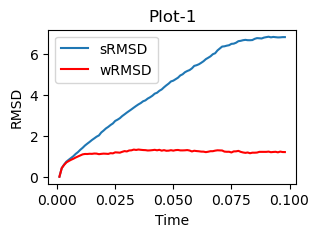

In [30]:
fig,ax = plt.subplots(1,1,figsize=(3.2,2))

sns.lineplot( df_gauss.sRMSD , ax=ax , label='sRMSD')
sns.lineplot( df_gauss.wRMSD , ax=ax,c='r', label='wRMSD')
ax.set_ylabel('RMSD')
ax.set_title('Plot-1')

Text(0.5, 1.0, 'Plot-2')

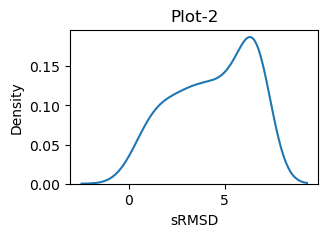

In [31]:
fig,ax = plt.subplots(1,1,  figsize=(3.2,2))
plt.subplots_adjust(hspace=0.4)
sns.distplot( df_gauss.sRMSD , hist=False, ax=ax)
ax.set_title('Plot-2')

Text(0.5, 1.0, 'Plot-3')

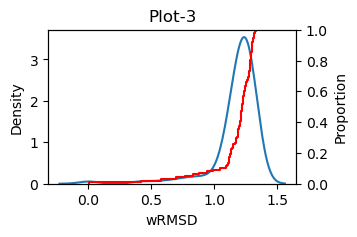

In [32]:
fig,ax = plt.subplots(1,1, figsize=(3.2,2))
tx = ax.twinx()
sns.distplot( df_gauss.wRMSD , hist=False, ax=ax)
sns.ecdfplot( df_gauss.wRMSD, ax=tx , color='r')
ax.set_title('Plot-3')

#### **Inferences**
- The traj analyzed here highlights transition of [closed to open](https://www.sciencedirect.com/science/article/abs/pii/S0022283609011164?via%3Dihub) conformation of enzyme adenylate kinase 
- The transition, as expected, results in the increase of sRMSD with respect to the starting conformation (Plot 1)
- Increase in sRMSD also results in broader distribution (Plot 2)
- The wRMSD is smaller than sRMSD, as the alignment ignores the contribution of most mobile regions (Plot 1 and 3)
- Proportion plot of wRMSD (Plot 3) shows almost 90% of analyzed frames has wRMSD < 1.2 (Plot 3)

#### Protein Rigidness
- To quantify the `rigid core` within the protein, we use stored final weights of atoms.
- To this end, we identify $C_{\alpha}$ atoms whose displacement is < 1.2 Ang or whose weights > 0.74
> ```python
 ( exp( -(1.2**2)/5.0 ) = 0.74
```

In [33]:
# Fraction of atoms with weights higher than 0.74
fn = lambda arr : len( arr[ arr > 0.74 ] )/ arr.size

In [34]:
df_weigh.head()

,R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,...,R205,R206,R207,R208,R209,R210,R211,R212,R213,R214
Time,,,,,,,,,,,,,,,,,,,,,
0.001,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.002,0.990507,0.983813,0.966405,0.972490,0.984162,0.959239,0.909210,0.877446,0.895497,0.928130,...,0.968560,0.991682,0.978349,0.983641,0.982507,0.948439,0.989742,0.979411,0.900401,0.951308
0.003,0.992650,0.973005,0.994163,0.946928,0.899749,0.926741,0.951697,0.904009,0.796727,0.874451,...,0.950883,0.956052,0.975435,0.964104,0.971843,0.956540,0.961235,0.951345,0.926405,0.932297
0.004,0.959887,0.991699,0.966736,0.927229,0.854173,0.978314,0.857724,0.707467,0.729521,0.905576,...,0.946533,0.913566,0.987344,0.989916,0.986632,0.844959,0.784239,0.869382,0.766705,0.730576
0.005,0.760536,0.964673,0.922877,0.944610,0.869960,0.885127,0.943967,0.709232,0.711489,0.954040,...,0.963897,0.976743,0.962921,0.973843,0.955989,0.836574,0.778331,0.949840,0.729514,0.776696


In [35]:
# For each frame, we obtain the fraction of rigid core
frac = df_weigh.apply( fn , axis=1)
frac

Time
0.001    1.000000
0.002    1.000000
0.003    0.981308
0.004    0.915888
0.005    0.901869
           ...   
0.094    0.359813
0.095    0.341121
0.096    0.373832
0.097    0.355140
0.098    0.341121
Length: 98, dtype: float64

Text(0.5, 1.0, 'Plot-4')

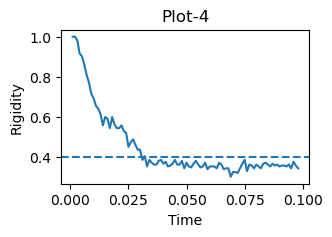

In [36]:
fig,ax = plt.subplots(1,1, figsize=(3.2,2))
sns.lineplot(frac,ax=ax)
ax.set_ylabel('Rigidity')
ax.axhline(0.4,ls='--')
ax.set_title('Plot-4')

In [37]:
# Here, for each atom, we estimate to what percentage it stays within 1.2 Ang displacement
Byres = df_weigh.apply( fn )
Byres

R1      0.887755
R2      0.959184
R3      1.000000
R4      0.969388
R5      0.704082
          ...   
R210    0.326531
R211    0.306122
R212    0.367347
R213    0.183673
R214    0.122449
Length: 214, dtype: float64

In [38]:
Byres.index = range(1,215)

Text(0.5, 1.0, 'Plot-5')

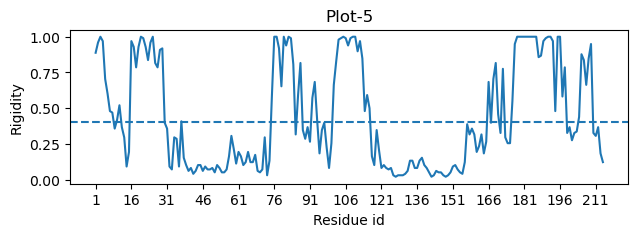

In [39]:
fig,ax = plt.subplots(1,1, figsize=(7.2,2))
sns.lineplot(Byres,ax=ax)
ax.set_ylabel('Rigidity')
ax.axhline(0.4,ls='--')
ax.set_xticks( range(1,215,15))
ax.set_xlabel('Residue id')
ax.set_title('Plot-5')

In [40]:
# Visualize the gaussfit traj, highlight rigid segments in green, whilst mobile as black
gfit = mda.Universe( finp_ref , fout_trj )
view = call_ngl( gfit )
view.add_cartoon('all',color='green')
# From Plot5, we color two regions of less rigidity
view.add_cartoon('36-70',color='black')
view.add_cartoon('116-163',color='black')
view

NGLWidget(layout=Layout(width='50%'), max_frame=97)

#### **Inferences**
- Reduction in rigidity as a function of simulation time correlates with the conformational transition (Plot 4).
- Quantification of residue level of rigidity (Plot 5) and visual representation (gfit traj) highlight the most mobile segments (black ribbons) displaying hinge motions upton conformational transition.